In [57]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
#provider = IBMQ.load_account()

# Algoritmo de Grover
- Introdução
- Preparação dos estados
- Aplicando Oracle
- Inversão sobre a média
- Circuito Quântico
- Exercícios

## Observações dos autores

- Recomendamos que antes de prosseguir para o algoritmo de Grover, o leitor esteja bem familiarizado com os algoritmos de Deutsch e a sua extensão Deutsch-Jozsa. Pois muitos dos conceitos já vistos lá são reutilizados neste módulo.
 



## Introdução 

 Dado um conjunto desordenado de elementos de tamanho $n$, como fazer para achar um elemento específico dentro do conjunto? A solução mais simples que não envolve a ordenação do conjunto implica a verificação de cada elemento do array até que o elemento desejado seja encontrado. No pior caso, seria necessário fazer $n$ requisições. O algoritmo proposto por Luv Grover tem a capacidade de fazê-lo em $\sqrt{N}$ vezes. 
 

## Preparação dos estados
   Considere o operador unitário $U_f$ que implementa a função(ou oracle) $f\{0,1\}^n \mapsto \{0,1\}$. Seja $\tilde{x}$ a cadeia binária a qual deseja-se achar. Onde $f(x) = 1$ se $x = \tilde{x}$ e $f(x) = 0$ se $ x \neq \tilde{x}$. A ação de $U_f$ nos estados dos qubits ocorreria da seguinte forma:
   $$
   U_f |x\rangle |y\rangle = |x\rangle |y  \oplus f(x) \rangle 
   $$
   
   O algoritmo em si faz uso de dois registradores quânticos, o primeiro trata-se de um registrador de $n$ qubits o qual é a entrada one será feita a busca o segundo registrador quântico trata-se do qubit auxiliar (ou ancilla).
   Mas antes de entrar nos detalhes do algoritmo é necessário fazer algumas observações, relaciondas a um passo importante na evolução do sistema chamado de _inversão de fase_.
   
   
   Considere uma entrada qualquer $|x\rangle$. O estado inicial do sistema se encontraria como a seguir:
   $$
     |x\rangle\left( \frac{|0\rangle - |1\rangle}{\sqrt{2}} \right)
   $$
   
   Distribuindo e aplicando $U_f$
  
   $$
       \frac{1}{\sqrt{2}}\left(|x\rangle|0\rangle - |x\rangle|1\rangle\right) = U_f\left[ \frac{1}{\sqrt{2}}\left(|x\rangle|0\rangle - |x\rangle|1\rangle\right) \right]
   $$
   $$
      \frac{1}{\sqrt{2}}\left(|x\rangle|0\oplus f(x) \rangle - |x\rangle|1\oplus f(x)\rangle\right)       
   $$
   
   Sabendo que $\oplus$ o qual trata-se de uma soma módulo 2, opera como um $XOR$ nos estados dos qubits. É possivel verificar que a operação $|1  \oplus f(x)\rangle$ trata-se da negação de $f(x)$. 
   Ou seja:
   $$
   |x\rangle \left(\frac{| f(x) \rangle - | \bar{f(x)}\rangle }{\sqrt{2}}\right)
   $$
   Levando este resultado em consideração, então a fase do sistema (ou sinal da equação) é determinada pelo resultado da função, matematicamente falando:
   $$
   (-1)^{f(x)}|x\rangle \left(\frac{| 0 \rangle - | 1\rangle }{\sqrt{2}}\right)
   $$
      
   Por simplicidade, vamos considerar que a entrada é uma superposição de todos os estados possíveis. Como se aplicássemos portas Hadamard do tipo $H^{\otimes n}$ a um registrador $|0\rangle^{\otimes n}$ . E que o estado inicial da ancila enconta-se como em $\frac{|0\rangle - |1\rangle}{\sqrt{2}}$.
   
   Para um sistema cuja entrada tem três qubits, o estado se encontraria como a seguir:
   $$
   \frac{1}{2}\left(|00\rangle + |01\rangle + |10\rangle + |11\rangle\right)\left(\frac{| 0 \rangle - | 1\rangle }{\sqrt{2}}\right)
   $$   
   Utilizando a API _Qiskit_ disponibilizada pela IBM a preparação do estado ficaria da seguinte forma:

In [24]:
qub = QuantumRegister(3,'q')
cb = ClassicalRegister(2,'c')
qc = QuantumCircuit(qub,cb)
qc.h(qub[0])
qc.h(qub[1])
#Preparando a ancila
qc.x(qub[2])
qc.h(qub[2])
#Drawing circuits
qc.draw()

## Aplicando o Oracle
 Agora seja $f$ uma função que "busca" pela cadeia $11$, então ao aplicar a inversão de fase o estado resultante ficaria da seguinte forma:
   
   $$
   \frac{1}{2}\left(|00\rangle + |01\rangle + |10\rangle - |11\rangle\right)\left(\frac{| 0 \rangle - | 1\rangle }{\sqrt{2}}\right)
   $$
  
  Explicando de forma simplificada, é como se o estado $11$ estivesse sendo marcado para que a busca pudesse ser efetuada.
  Um operador que já implementa esta função é o operador $Toffoli$ o qual já se encontra implementado na API do _Qiskit_.

In [25]:
qc.ccx(qub[0], qub[1], qub[2])
qc.draw()

 Para fins de demonstração efetuaremos uma medição nos qubits para verificar as probabilidades do sistema somente com a inversão de fase.

In [26]:
qc.measure(qub[0],cb[0])
qc.measure(qub[1],cb[1])
qc.draw()

Considerando este reusltado podemos fazer as seguintes observações: Se aplicarmos uma medição nos qubits superiores qualquer um dos estados poderia ser retornado com mesma probabilidade dado que $\left| \frac{1}{2} \right|^2 = \left| - \frac{1}{2} \right|^2 $ o que não é muito interessante para quem faz a busca.
   Por isso que o algoritmo de Grover faz uso de um passo muito importante para resolver este problema chamado de _inversão sobre a média_. 

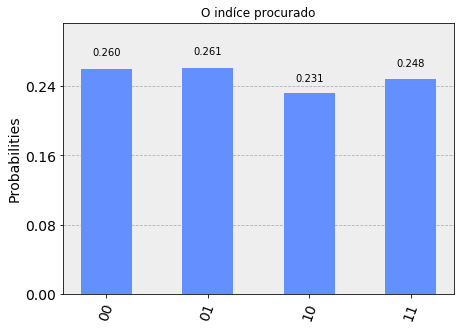

In [27]:
# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(qc, simulator).result()
counts = result.get_counts(qc)
plot_histogram(counts, title='O indíce procurado')

## Inversão sobre a média

   Considere a o seguinte vetor de tamanho $5$ com os seguintes valores : $\left[4,5,10,3,3\right]$. Sabendo que média desses números é $5$, como inverter seus valores em relação à média? Primeiramente deve-se calcular a distância entre o valor e a média, matemáticamente isto é feito subtraindo a média $m$ e o valor $v$: $m-v$ . Em seguinda pegamos o resultado e o somamos à média mais uma vez: $m - v + m$ ou $ -v + 2m$. 
    
   Agora considere que ao inves de calcular a inversão sobre a média de cada valor individualmente, queiramos calcular a inversão sobre a média dos valores no vetor utilizando operações matriciais. Como fazê-lo?
   
   Sabendo que para calcular a média soma-se todos os valores e o resultado é dividido pelo número de valores somados. Ou seja $\frac{1}{n}\sum_{i=1}^{n} x_i$ ,  para $n$ o número de valores somados e $x_i$ o $i$-ésimo valor. Agora considere o coeficiente $\frac{1}{n}$. Retomando o uso do vetor $\left[4,5,10,3,3\right]$ podemos calcular a média desse vetor aplicando a seguinte operação: 
   $$\left[\begin{array}{ccccc}
   \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} \\
   \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} \\
   \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} \\
   \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} \\
   \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} & \frac{1}{5} \\
   \end{array}\right]
   \left[\begin{array}{c}
   4 \\
   5 \\
   10\\
   3 \\
   3 \\
   \end{array}\right] 
   = 
   \left[\begin{array}{c}
   5 \\
   5 \\
   5\\
   5 \\
   5 \\
   \end{array}\right]$$
   
   As células da primeira matriz estão todas com valor $\frac{1}{5}$ pois trata-se do coeficiente utilizado no somatório da média. Por simplicidade chamaremos a matriz cujas todas células estão com valor $\frac{1}{5}$ de $A$. 
   
   Desse modo, matricialmente falando. A operação de inversão sobre a média de um vetor $V$ ocorre da seguinte forma:
   $$
   \bar{V} = -V + 2AV 
   $$
   Evidenciando o vetor $V$ obtemos: $(-I + 2A)V$. Desse modo, o operador de inversão sobre a média é obtido a partir da operação matricial: 
   $$
   -I + 2A
   $$
   
   ### Implementando inversão sobre a média
   
   Sob a perspectiva de computação quântica este operador pode ser obtido a partir da seguinte fórmula: 
   
   $$
   H^{\otimes n}\left(2|0\rangle\langle0| - I \right)H^{\otimes n}
   $$
   
   Considerando a entrada do sistema $|\psi\rangle$, a qual será efetuada a busca, como de uma superposição de todos os estados possíveis. Ou seja :   $H^{\otimes n} | 0 \rangle^{\otimes n} = |\psi\rangle$.
   E Considerando tanto $|0\rangle$ como $\langle 0|$ como vetores de dimensão $n$ obtemos:
   
   $$
   2|\psi\rangle\langle\psi | - I
   $$
   
   Do ponto de vista de implementação o passo a passo para aplicar a inversão sobre a média no sistema seria da seguinte forma: 
   1. Aplicar transformações de Hadamard $H^{\otimes n}$
   2. Aplicar mudança de fase condicional nos estados, com toda a base computacional recebendo -1 exceto o estado $|0\rangle^{\otimes n}$  <br>
$|x\rangle \rightarrow -(-1)^{\delta_x0}|x\rangle$ <br>
   3. Reaplicar transformações de Hadamard $H^{\otimes n}$
   
   A aplicação do operador $U_f$(ou oracle)junto com os três passos $1,2$ e $3$ compõe a interação de Grover ou _Grover's interation_.
  O algoritmo tem que ser executado até $\sqrt{N}$ vezes, mais especificamente a aplicação da interação de Grover no sistema. 

# Circuito Quântico

In [61]:
#Inicialização dos estados
qub = QuantumRegister(3,'q')
cb = ClassicalRegister(2,'c')
qc = QuantumCircuit(qub,cb)
qc.h(qub[0])
qc.h(qub[1])
#Preparando a ancila
qc.x(qub[2])
qc.h(qub[2])

#Interação de grover
for i in range(int(np.ceil(np.sqrt(4)))):
    # Oracle
    qc.ccx(qub[0], qub[1], qub[2])

    #---Hadamard
    qc.h(qub[0])
    qc.h(qub[1])

    #----Troca de fase
    qc.z(qub[0])
    qc.z(qub[1])

    #--- Hadarmard
    qc.h(qub[0])
    qc.h(qub[1])

qc.draw()

Após a última aplicação podemos efetuar a medição dos qubits da entrada, ou seja  efetuar a medição nos qubits $0$ e $1$. 
O circuito quântico resultante ficaria então da seguinte forma:

In [62]:
qc.measure(qub[0],cb[0])
qc.measure(qub[1],cb[1])
qc.draw()

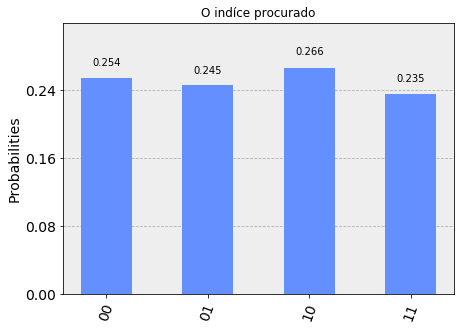

In [69]:
# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(qc, simulator).result()
counts = result.get_counts(qc)
plot_histogram(counts, title='O indíce procurado')

## Exercício

 1. Calcule os valores invertidos sobre a média de cada valor do vetor $\left[4,5,10,3,3\right]$
 
 2. Mostre que $A^2 = A$
 
 3. Mostre que $-I + 2A$ é um operador unitário, ou seja que $(-I + 2A)(-I + 2A)^{\dagger} = I$. 
 
 4. O que acontece se repetirmos o exemplo porém aplicarmos _inversão de fase_ e inversão sobre a média quatro vezes?
 
 5. Fazer o exemplo para uma entrada de três qubits onde $f$ "escolhe" a cadeia 001
 6. Crie um circuito quântico utilizando um oracle diferente. Dica:Verifique a ação de $U_f$ sobre os estados da base ( incluindo a ancila )